In [ ]:
import mylib
import seaborn as sns
from bs4 import BeautifulSoup as bs
sns.set(rc={'figure.figsize': [10, 10]}, font_scale=1.2)
import pandas as pd

In [ ]:
df=mylib.Describe.describeDf('../DataSet/Data_Train.xlsx')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB
None
              Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000


In [ ]:
arw=df['Route'].unique()[1][4]
df['Route']=df['Route'].apply(  lambda x : ('/'.join([i for i in x.split(arw)]).replace(" ", "")if(type(x)!=float) else'') )

In [ ]:
from joblib import load
pagesrc = load('../DataSet/Routs_objects.h5')
Distance = {}
for i in pagesrc:
        soup = bs(i, 'html.parser')
        value = soup.find('span', class_='value km')
        index = soup.find('a', class_='main-route trip')
        if value is None and index is None:
                continue
        Distance.update({index['href'][1:]: ''.join([i for i in value.text if i != ','])})
df['Distance'] = df['Route'].map(Distance)
df['Distance'] = df['Distance'].astype(float)

In [ ]:
def x(z):
        z = z.split(" ")
        if len(z) == 1:
                return int(z[0][:-1]) * 60
        else:
                return (int(z[0][:-1]) * 60) + int(z[1][:-1])


df['Duration'] = df['Duration'].apply(x)
df['Total_Stops'] = df['Total_Stops'].fillna('non-stop')
df['Total_Stops'] = df['Total_Stops'].apply(lambda x: x[0] if x[0] != 'n' else 0)

In [ ]:
df['Additional_Info'].replace("No Info",'No info',inplace=True)
df['Additional_Info'].value_counts()

No info                         8348
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [ ]:
x=df[df['Additional_Info'].isin(["1 Long layover","Change airports","Red-eye flight"])].index
df.drop(x,inplace=True)

In [ ]:
x=df[df['Airline'].isin([k  for k,i  in df['Airline'].value_counts().iteritems() if i <100])].index
df.drop(x,inplace=True)

In [ ]:
df['Route'].value_counts()

DEL/BOM/COK        2362
BLR/DEL            1549
CCU/BOM/BLR         979
CCU/BLR             724
BOM/HYD             621
                   ... 
CCU/RPR/HYD/BLR       1
CCU/IXZ/MAA/BLR       1
CCU/VTZ/BLR           1
BOM/CCU/HYD           1
BOM/BBI/HYD           1
Name: Route, Length: 127, dtype: int64

In [ ]:
x=df[df['Route'].isin([k  for k,i  in df['Route'].value_counts().iteritems() if i <10])].index
df.drop(x,inplace=True)

In [ ]:
mylib.Manipulation.outliers(df,['Distance','Price','Duration'],True)

906


array([[<AxesSubplot:title={'center':'Duration'}>,
        <AxesSubplot:title={'center':'Price'}>],
       [<AxesSubplot:title={'center':'Distance'}>, <AxesSubplot:>]],
      dtype=object)

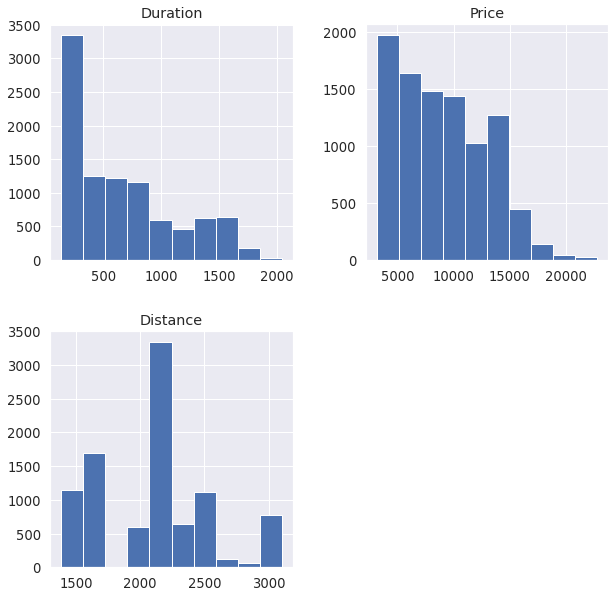

In [ ]:
df.hist()

In [ ]:
import  mylib as mlb
mlb.Manipulation.outliers(df,['Distance','Duration','Price'],True)

2


array([[<AxesSubplot:title={'center':'Duration'}>,
        <AxesSubplot:title={'center':'Price'}>],
       [<AxesSubplot:title={'center':'Distance'}>, <AxesSubplot:>]],
      dtype=object)

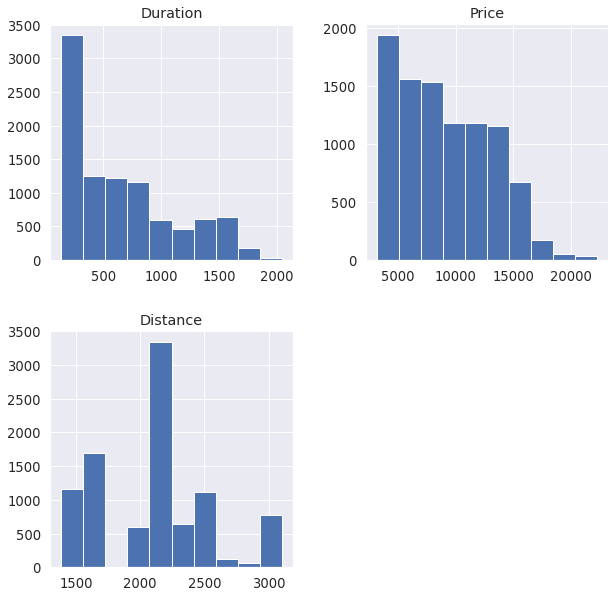

In [ ]:
df.hist()

,Duration,Price,Distance
Additional_Info,,,
In-flight meal not included,879.200864,9772.951404,2271.356463
No check-in baggage included,159.454887,3958.421053,1593.500526
No info,608.026013,9057.715486,2107.859556


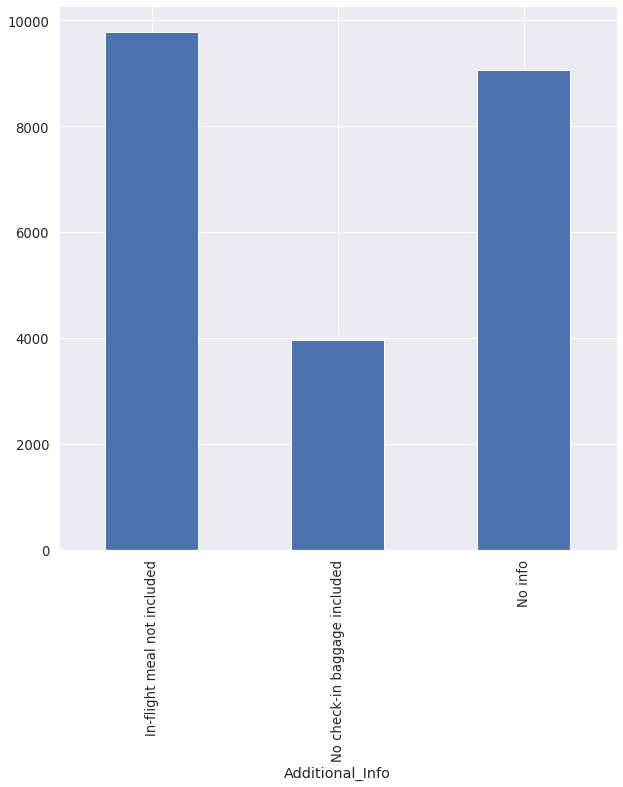

In [ ]:
x=df.groupby(df['Additional_Info']).mean()
x['Price'].plot(kind='bar')
x

In [ ]:
df.drop(['Date_of_Journey','Source','Destination','Dep_Time','Arrival_Time'],inplace=True,axis=1)

<AxesSubplot:xlabel='Additional_Info', ylabel='Price'>

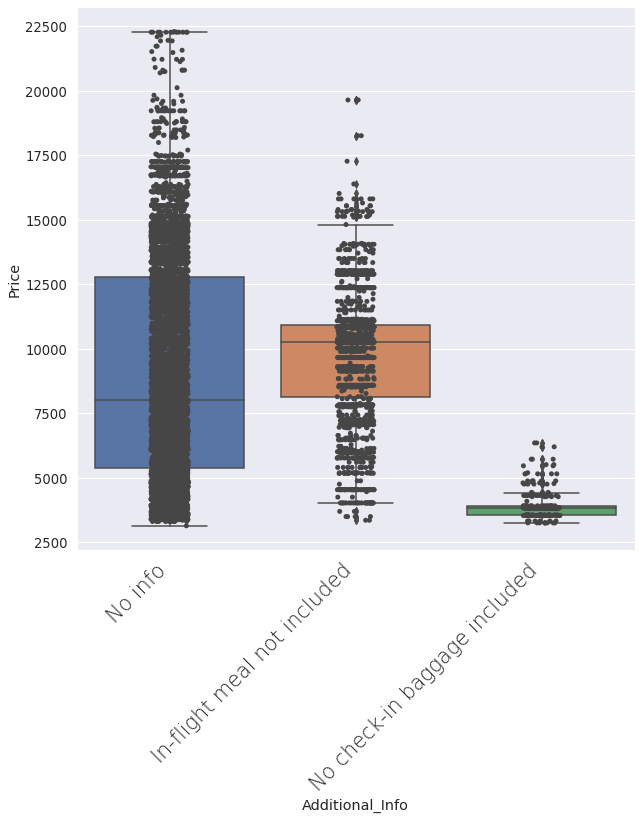

In [ ]:
mlb.Visualization.inc_plt()
sns.boxplot(x="Additional_Info", y="Price", data=df)
sns.stripplot(x="Additional_Info", y="Price", color="#474646", size=5, data=df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9499 entries, 0 to 10682
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Airline          9499 non-null   object 
 1   Route            9499 non-null   object 
 2   Duration         9499 non-null   int64  
 3   Total_Stops      9499 non-null   object 
 4   Additional_Info  9499 non-null   object 
 5   Price            9499 non-null   int64  
 6   Distance         9499 non-null   float64
dtypes: float64(1), int64(2), object(4)
memory usage: 593.7+ KB


In [ ]:
# from datashader import Pipeline
ohe_cols=['Airline','Route','Additional_Info']
# from  sklearn.preprocessing import  OneHotEncoder
# onehotencoder=OneHotEncoder()
# features=onehotencoder.fit_transform(df[x]).toarray()

In [ ]:
# Cols=[]
# c=0
# for i in onehotencoder.categories_:
#      for x in i:
#         Cols.append(x[c]+'_'+x )
#      c+=1
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df

,Airline,Route,Duration,Total_Stops,Additional_Info,Price,Distance
0,IndiGo,BLR/DEL,170,0,No info,3897,1710.05
1,Jet Airways,DEL/LKO/BOM/COK,1140,2,No info,13882,2670.87
2,SpiceJet,CCU/BLR,145,0,No info,3873,1546.84
3,Jet Airways,BLR/BOM/DEL,930,1,In-flight meal not included,11087,1972.40
4,Jet Airways,BLR/BOM/DEL,1265,1,No info,22270,1972.40
...,...,...,...,...,...,...,...
9494,Air Asia,CCU/BLR,150,0,No info,4107,1546.84
9495,Air India,CCU/BLR,155,0,No info,4145,1546.84
9496,Jet Airways,BLR/DEL,180,0,No info,7229,1710.05
9497,Vistara,BLR/DEL,160,0,No info,12648,1710.05


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder =LabelEncoder()

df['Additional_Info']= label_encoder.fit_transform(df['Additional_Info'])
df['Additional_Info'].unique()

array([2, 0, 1])

In [24]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
import numpy as np
y,X=df['Price'],df.drop(['Price'],axis=1)

col_transform = ColumnTransformer(transformers=[('cat', OneHotEncoder(), ['Airline','Route']),
                                               # ('le',LabelEncoder(),['Additional_Info']),
                                               ('mx',MinMaxScaler(),['Distance','Duration'])]
                                               , remainder='passthrough')
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('prep',col_transform), ('m', model)])
cv = KFold(n_splits=10, shuffle=True, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1,error_score='raise')
scores = np.absolute(scores)
print('MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

MAE: 1228.971 (75.135)


In [25]:
from sklearn.model_selection import RandomizedSearchCV

rscv = RandomizedSearchCV(pipeline,
                          n_iter = 1,
                          scoring = 'r2',
                          cv = 5,
                          n_jobs = 5,
                          param_distributions = {
                              'model__criterion': ['squared_error'],
                              'model__max_depth' : [50],
                          })

result = rscv.fit(X, y)
result

ValueError: Invalid parameter model for estimator Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['Airline', 'Route']),
                                                 ('mx', MinMaxScaler(),
                                                  ['Distance', 'Duration'])])),
                ('m', RandomForestRegressor())]). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
xxxxx

In [ ]:
x = pd.get_dummies(df, columns=['Airline'], drop_first=True).drop(['Route'],axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

models = {
        'LR': LinearRegression(),
        'DT': DecisionTreeRegressor(),
        'KNN': KNeighborsRegressor(3),
        'RF': RandomForestRegressor(n_estimators=120),
}

for name, model in models.items():
        print(f'Training {name}...')
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        yt_pred = model.predict(x_train)
        print(f'Testing RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
        print(f'Testing MAE: {mean_absolute_error(y_test, y_pred)}')
        print(f'r2_score: {r2_score(y_test, y_pred)}')
        print(f'Testing R2: {r2_score(y_test, y_pred)}')
        print(f'train RMSE: {np.sqrt(mean_squared_error(y_train, yt_pred))}')
        print(f'train MAE: {mean_absolute_error(y_train, yt_pred)}')
        print(f'train R2: {r2_score(y_train, yt_pred)}')
        print('-'*50)
